# The idea

The present study aims to research how different syntactic relations interact with the possibility of head nouns and their dependents to be in different verses in a Russian poetic text.

The hypothesis is that the more distant the relation is in syntactic terms, the easier for a constituent is to be split into different verses. For some syntactic relations it is clear which relations are more "close" and which are less. For example, most syntax theories suppose that subjects are projected along with the V-DO complex, while adverbs can adjoin constituents, including both S and V-DO. The example of the described structure is: \[Вчера \[Вася \[встретил \[соседа\]\]\]\]. Thus, the direct object in this structure is closest to the verb, the subject is farther and the adverb is even farther.

It is not clear how to compare the described relations inside verbal / sentential projections and the relations with other heads, but some tests, e. g. based on word order, lead to a conclusion that the relations inside NP are more fixed than in verbal / sentential projections. In this study I will restrict the set of discussed relations to Adv, S, DO in the verbal domain and Adj in the nominal domain.

The hypothesis is thus that the more is a relation on the right of the hierarchy _Adv > S > DO > Adj_, the less freely the dependents must be able to occur on a different verse from its head.

The database that I create is really big, so I don't upload it to GitHub. It can be found by the link: https://disk.yandex.com/d/E0QFIUVjxj8x9A

What is new? This cell lists what new has been done in the project, compated to the homework.

- Histograms for the distributions of the distance of a word with some syntactic relation and its head (plots 2 and 3)
- Different conformations of the fact that the ordering of syntactic relations is not solely due the difference of distances from the head are given:
    - I generated a datacet with the same distribution of verse lenghths and distances between heads and dependents and showed that the distance per se predicts a smoller effect (it seems for me to be the most different and quite an important part)
    - I counted the differences in sameness of the verse for the set distance from the head (with statictical confirmation of the results)
- A case-study on adverbs

Minor changes:

- Some aggregated / statistical tables are sorted to look nicer.
- Comments are rewritten in a less homework-like way.
- Corrections of some mistakes, i. g. prepositional phrases were counted among adverbs

In [5]:
import spacy
import sqlite3
import pandas as pd
import numpy
import random
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import chisquare
import statsmodels.formula.api as smf

In [6]:
def int_check_none(a):
    if a == None:
        return None
    else:
        return int(a)

def decadize(date):
    if date == None:
        return None
    else:
        return int(date) // 50 * 50

I use the collection of poetic texts, provided by Ilia Gusev: https://github.com/IlyaGusev/PoetryCorpus/blob/master/datasets/corpus/all.xml. See more on the collection here: https://github.com/IlyaGusev/PoetryCorpus.

The collection is preproсesed and turned into a database, consisting of 3 tables. The first one comprises information about each text, inсluding meta-information, the second one — information about verses, the third one — information about separate words, including morphological and syntactic tags and information about the head of the word.

In [3]:
tree = ET.parse('all.xml')
root = tree.getroot()

In [4]:
nlp = spacy.load("ru_core_news_md")

In [ ]:
#Creating a database
#Table 1: meta-information
#Table 2: verses
#Table 3: words


con = sqlite3.connect("poetry.db")
c = con.cursor()

c.execute("DROP TABLE IF EXISTS meta")
c.execute("CREATE TABLE meta (id,author,year,half_century,name);")

c.execute("DROP TABLE IF EXISTS verses")
c.execute("CREATE TABLE verses (id,id_in_poem,poem_id,text);")

c.execute("DROP TABLE IF EXISTS words")
c.execute("CREATE TABLE words (id,word,id_in_poem,verse_id,poem_id,lemma,POS,morph_tags,synt_tag,head,head_id);")

word_id = 0

verse_id = 0

verse_id_words = 0

for i, poem in enumerate(root):
    
    verse_sizes = []
        
    verse_size = 0
        
    verse_id_words_in_poem = 0
    
    c.execute("INSERT INTO meta VALUES (?, ?, ?, ?, ?)",
              (i, poem[1].text, int_check_none(poem[2].text), decadize(poem[2].text), poem[4].text))
  
    for j, verse in enumerate(poem[3].text.split('\n')):
        
        verse_size += len(nlp(verse))
        
        verse_sizes.append(verse_size)
              
        c.execute("INSERT INTO verses VALUES (?, ?, ?, ?)",
              (verse_id, j, i, verse))
        
        verse_id += 1
    
    poem_analyzed = nlp(poem[3].text.replace('\n', ' '))
    
    for id_in_poem, word in enumerate(poem_analyzed):
                   
        c.execute("INSERT INTO words VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)",
          (word_id, str(word), id_in_poem, verse_id_words, i,
           word.lemma_, word.pos_, str(word.morph), word.dep_, str(word.head), 
           word.head.i + (word_id - word.i)))
        
        word_id += 1
        
        if verse_sizes[verse_id_words_in_poem] <= id_in_poem:
            verse_id_words_in_poem += 1
            verse_id_words += 1
        
    verse_id_words_in_poem += 1
    verse_id_words += 1
        
con.commit()

con.close()

In [7]:
con = sqlite3.connect("poetry.db")
c = con.cursor()    

In [8]:
#Creating dataframes from the database

words_all = pd.read_sql_query("SELECT * FROM words", con)
words_all

,id,word,id_in_poem,verse_id,poem_id,lemma,POS,morph_tags,synt_tag,head,head_id
0,0,Забывши,0,0,0,забывши,NOUN,Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing,nsubj,жил,6
1,1,волнения,1,0,0,волнение,NOUN,Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing,nmod,Забывши,0
2,2,жизни,2,0,0,жизнь,NOUN,Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing,nmod,волнения,1
3,3,мятежной,3,0,0,мятежный,ADJ,Case=Gen|Degree=Pos|Gender=Fem|Number=Sing,nmod,жизни,2
4,4,",",4,0,0,",",PUNCT,,punct,Забывши,0
...,...,...,...,...,...,...,...,...,...,...,...
2767238,2767238,-,302,486638,16693,-,ADV,Degree=Pos,parataxis,погасло,2767233
2767239,2767239,Высоко,303,486638,16693,высоко,ADV,Degree=Pos,obl,погасло,2767233
2767240,2767240,и,304,486639,16693,и,CCONJ,,cc,красно,2767241
2767241,2767241,красно,305,486639,16693,красный,ADJ,Animacy=Inan|Case=Acc|Degree=Pos|Gender=Neut|N...,conj,Высоко,2767239


In [9]:
meta = pd.read_sql_query("SELECT * FROM meta", con)
meta

,id,author,year,half_century,name
0,0,Михаил Лермонтов,1829.0,1800.0,Забывши волнения жизни мятежной...
1,1,Сергей Есенин,1917.0,1900.0,"Нивы сжаты, рощи голы..."
2,2,Игорь Северянин,1919.0,1900.0,ЧАРЫ ЛЮЧИНЬ
3,3,Анатолий Жигулин,1963.0,1950.0,Золото
4,4,Николай Тихонов,1937.0,1900.0,Хоровод в Сульдуси
...,...,...,...,...,...
16689,16689,Леонид Мартынов,1967.0,1950.0,Ноябрь
16690,16690,Гаврила Державин,1798.0,1750.0,Параше
16691,16691,Федор Сологуб,1880.0,1850.0,Рифма
16692,16692,Илья Эренбург,1924.0,1900.0,Я так любил тебя — до грубых шуток...


In [10]:
verses = pd.read_sql_query("SELECT * FROM verses", con)
verses

,id,id_in_poem,poem_id,text
0,0,0,0,"Забывши волнения жизни мятежной,"
1,1,1,0,Один жил в пустыне рыбак молодой.
2,2,2,0,"Однажды на скале прибрежной,"
3,3,3,0,Над тихой прозрачной рекой
4,4,4,0,Он с удой беспечно
...,...,...,...,...
486635,486635,63,16693,Не захотел - а сжег.
486636,486636,64,16693,"Гори, гори ясно,"
486637,486637,65,16693,"Чтобы не погасло,"
486638,486638,66,16693,Чтобы не напрасно -


In [11]:
con.close()

I filter and modify the data to get a dataset which includes nominal subjects and objects, adjectival and adverbial modifiers. For each of them the information if the word is in the same verse as its head or they are in different ones is contained.

Clearly, some part of the database is not immediately needed in the study or is not needed in it at all. However, this data can be used in other research of Russian poetry.

In [12]:
#Joining two dataframes to understand in which verse is a head of a word

head_verses = words_all.loc[:, ['head_id', 'verse_id']].join(
    words_all.loc[:, ['id', 'verse_id']].set_index('id'),
    on='head_id', validate='m:1', rsuffix = '_head')

words_all['verse_id_head'] = head_verses['verse_id_head']

In [13]:
#Creating a coloumn which says if the head is in a different verse

words_all['Head_verse'] = numpy.where(words_all['verse_id'] == words_all['verse_id_head'], 'same', 'different')

In [14]:
#Leaving only words of the required parts of speach

words = words_all[words_all['POS'].isin(['ADJ', 'ADV', 'DET', 'NOUN', 'PRON', 'PROPN', 'VERB'])]
words = words[words['word'].str.contains('-')==False]

In [15]:
#Filtering rows with required syntactic relations

words_some_relations = words.loc[:, 
        ['synt_tag', 'Head_verse']][words['synt_tag'].isin(
        ['nsubj', 'obj', 'amod', 'advmod'])]

In [16]:
#Aggregating data

transitions = words_some_relations.groupby(["synt_tag", 'Head_verse']).size()
transitions = transitions.reset_index(name='n')
transitions['fraction'] = transitions.groupby('synt_tag')['n'].transform(lambda x: round(x/sum(x), 2))
transitions['synt_tag'] = pd.Categorical(transitions['synt_tag'], ["nsubj", "obj", "advmod", "amod"])
transitions.sort_values('synt_tag')

,synt_tag,Head_verse,n,fraction
4,nsubj,different,112467,0.46
5,nsubj,same,131112,0.54
6,obj,different,41860,0.37
7,obj,same,72007,0.63
0,advmod,different,35814,0.37
1,advmod,same,61524,0.63
2,amod,different,30799,0.20
3,amod,same,122521,0.80


The table shows the number of the words with its head in the same and in different verses and percentages of both for each syntactic relation.

The hypothesis proved to be only partially correct: the order in the hierarchy is _S > Adv, DO > Adj_ with an adverb at the different position, while the expected order was _Adv > S > DO > Adj_.

This order is also theoretically reasonable, as adverbs are not a homogeneous class. While some adverbs, like _вчера_ are expected to be "farther" from the verb, some others, like _быстро_ are placed between S and DO in the structure. It appears that the number of the adverbs of the second type is higher than the number of the first type. I will discuss the differences between types of adverbs in more detail later.

The difference between groups is clearly visible on the histogram below. For almost a half of nominal subjects the head is in a separate verse, for adjective modifiers the head in most cases in the same verse, while direct objects and adverbs are in between.

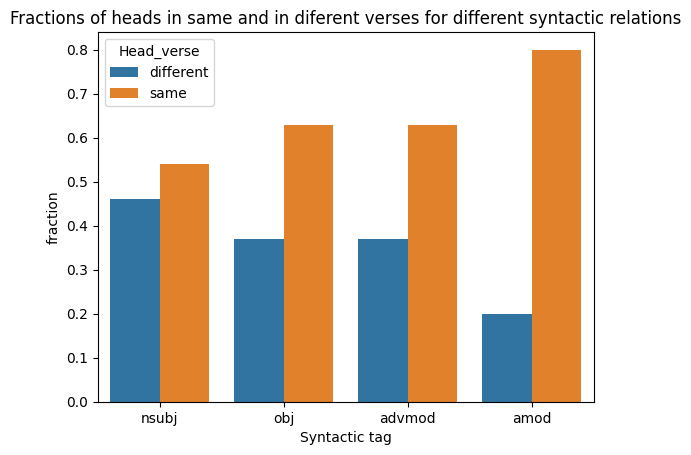

In [17]:
#Plot 1

sns.barplot(x="synt_tag", y="fraction", hue='Head_verse', data=transitions)
plt.title('Fractions of heads in same and in diferent verses for different syntactic relations')
plt.xlabel('Syntactic tag')
plt.ylabel('fraction');

To check the significance of the observed difference, I count χ-square for the contaguancy table below:

In [18]:
cont_table_head_verses = transitions.pivot_table(values='n', index=['Head_verse'],
                        columns=['synt_tag'], aggfunc=numpy.sum)
cont_table_head_verses

synt_tag,nsubj,obj,advmod,amod
Head_verse,,,,
different,112467,41860,35814,30799
same,131112,72007,61524,122521


The difference is statistically significant with incredibly small p-value (which is not surprising, regarding the size of the dataset).

In [19]:
# Additional task: statistical inference

chisquare(cont_table_head_verses, axis=None)

Power_divergenceResult(statistic=152348.41335034795, pvalue=0.0)

The observed differences may turn out to be epiphenomenal and, for example, follow from the fact that closer syntactic constituents are usually also close in the sense of the number of words between them.

The latter assumption appears to be true, as it is shown below. Both mean and quartiles show that the closeness of the dependent to its head (where 1 stands for _right near the head_ 2 is _separated by 1 word from it_ and so on) aligns with the same hierarchy _S > Adv > DO > Adj_.

In [20]:
#More manipulations with the dataframes

words['head_distance'] = abs(words['id'] - words['head_id'])

words_some_relations_distances = words.loc[:, ['synt_tag', 'head_distance']][words['synt_tag'].isin(
        ['nsubj', 'obj', 'amod', 'advmod'])]


words_some_relations_distances.groupby('synt_tag').agg(Mean=('head_distance', numpy.mean),
                        quartile_1=('head_distance', lambda a: numpy.quantile(a, 0.25)),
                        quartile_3=('head_distance', lambda a: numpy.quantile(a, 0.75))
                                                      ).sort_values('Mean', ascending=False)

,Mean,quartile_1,quartile_3
synt_tag,,,
nsubj,2.607680,1.0,3.0
advmod,2.265559,1.0,3.0
obj,2.229004,1.0,2.0
amod,1.255133,1.0,1.0


The plots below demonstrate the observed distributions of the distance in more detail. Plot 2 shows actual differences in distance distributions for different syntactic relations; Plot 3 with a logarithmic y allows to see the trend for larger distances, Plot 5 shows the distribution in a form of violin plots. 

Text(0.5, 0.98, 'The distance distributions for different syntactic relations')

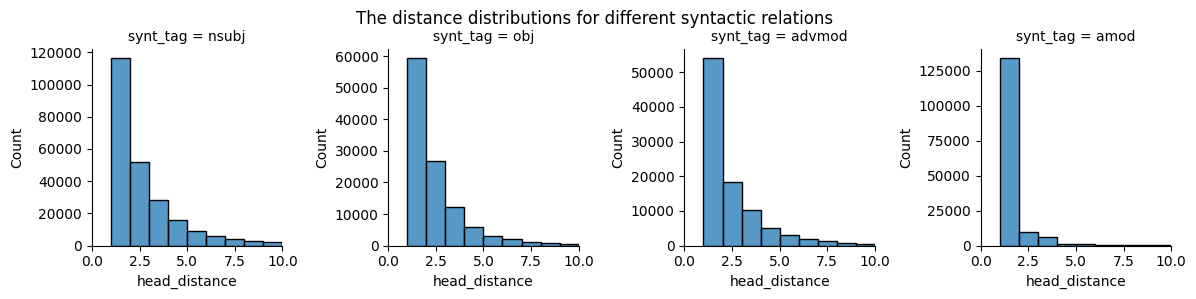

In [21]:
#Plot 2

g = sns.FacetGrid(words_some_relations_distances, col = "synt_tag",
                  sharey = False, xlim = (0,10), col_order = ['nsubj', 'obj','advmod', 'amod'])
g.map(sns.histplot, "head_distance", binwidth=1)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('The distance distributions for different syntactic relations')

Text(0.5, 0.98, 'The distance distributions for syntactic relations, logscale')

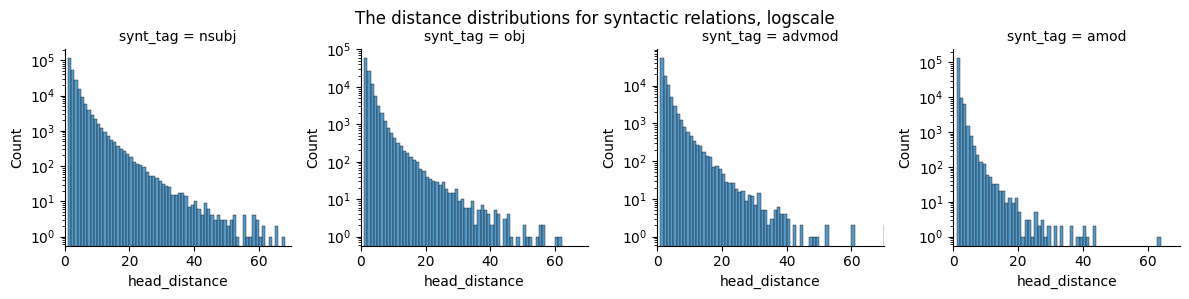

In [22]:
#Plot 3

g = sns.FacetGrid(words_some_relations_distances, col = "synt_tag",
                  sharey = False, xlim = (0,70), col_order = ['nsubj', 'obj','advmod', 'amod'])
g.map(sns.histplot, "head_distance", log_scale = [False, True], binwidth=1)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('The distance distributions for syntactic relations, logscale')

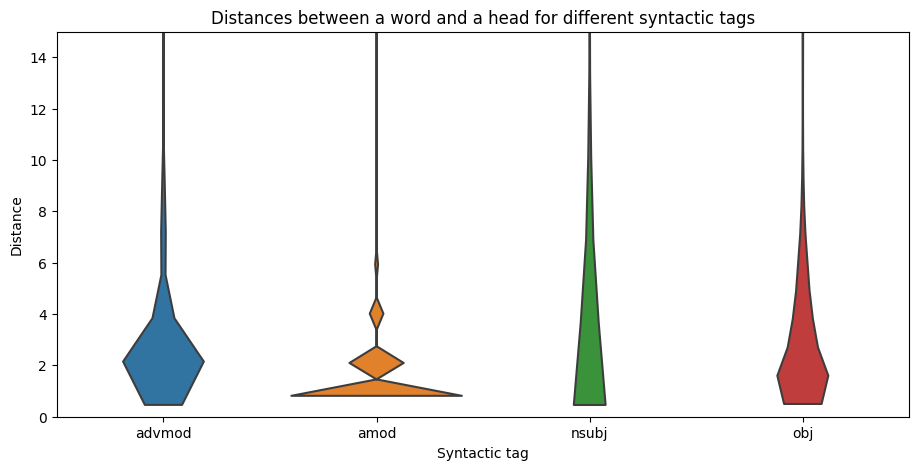

In [23]:
#Plot 4

plt.figure(figsize=(11, 5))
sns.violinplot(x='synt_tag', y='head_distance', data=words_some_relations_distances, inner=None,
               order=['advmod', 'amod', 'nsubj', 'obj'])
plt.ylim((0, 15))

plt.title('Distances between a word and a head for different syntactic tags')
plt.xlabel('Syntactic tag')
plt.ylabel('Distance')
plt.show()

Notice, however, that the difference between syntactic relations in linear distance from the head is not as dramatic as in same / different verse opposition: 75% of nouns are not farther than 3 from their heads, while almost half of them are in a different verse.

This observation is supported by the fact that the size of a verse in words is usually bigger than 3. As it is shown in the Plot 3 and in the table before it, numbers of words in a verse concentrate near 5 in one verse.

In [24]:
verse_sizes = words_all.loc[:, ['id', 'verse_id']].join(
    verses.loc[:, ['id']].set_index('id'),
    on='verse_id', validate='m:1').groupby('verse_id').count()


verse_sizes_summarized = verse_sizes.reset_index().groupby('id').count()

verse_sizes_summarized['fraction'] = verse_sizes_summarized['verse_id'] / sum(verse_sizes_summarized['verse_id'])

verse_sizes_summarized.head(10)

,verse_id,fraction
id,,
1,5414,0.011126
2,17113,0.035168
3,44043,0.090511
4,82702,0.169957
5,98891,0.203226
6,89130,0.183167
7,63113,0.129700
8,40297,0.082812
9,22802,0.046859


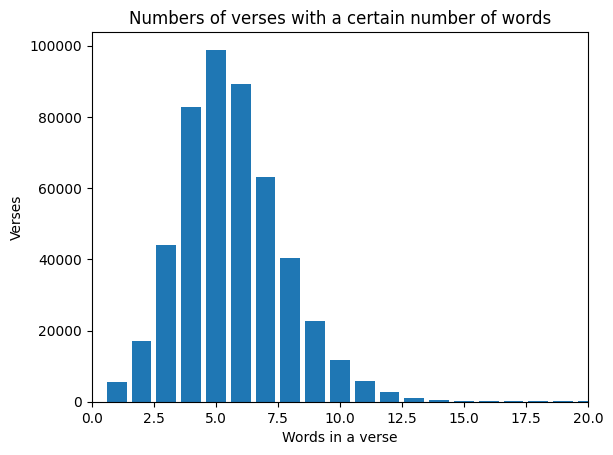

In [25]:
#Plot 5

plt.xlim(0, 20)
plt.bar('id', 'verse_id', data=verse_sizes_summarized.reset_index())
plt.title('Numbers of verses with a certain number of words')
plt.xlabel('Words in a verse')
plt.ylabel('Verses')
plt.show()

To confirm the fact that the distence does not solely explain the differences between the types of syntactic relations I generate an artificial dataset, which has the same distances distribution for syntactic tags, but does not reflect information about the syntactic structures.

In order to do that, I randomely select 200000 verse sized and for each of them randomly choose the dependent position. For each of syntactic relations I use the same 200000 verses and randomly select for each of them the dictance of a dependent from its head. This allows to calculate if the head in each case in the same generated verse or it is out of it.

In [26]:
random_verses = verse_sizes.sample(n=200000, replace=True)['id']
random_verses = pd.DataFrame(list(random_verses), columns = ['wnumber'])
random_verses['head_position'] = random_verses.apply(lambda row: random.randint(1, row['wnumber']), axis=1)

In [27]:
verses_sample = pd.DataFrame(columns = [])

for synt_tag in ['nsubj', 'obj', 'advmod', 'amod']:
    new_rw = random_verses
    new_rw['synt_tag'] = synt_tag
    random_verses['dependent_position_difference'] = list(words_some_relations_distances.loc[
        words_some_relations_distances['synt_tag'] == synt_tag].sample(n=200000, replace=True)['head_distance'])
    verses_sample = pd.concat([verses_sample, new_rw])

In [28]:
verses_sample['neg'] = (1, -1) * 400000

verses_sample['dependent_position'] = verses_sample['head_position'] - verses_sample['dependent_position_difference'] * verses_sample['neg']

verses_sample['Head_verse'] = numpy.where(
    ((verses_sample['dependent_position'] < 1) |
      (verses_sample['dependent_position'] > verses_sample['wnumber'])), 'different', 'same')

verses_sample

,wnumber,head_position,synt_tag,dependent_position_difference,neg,dependent_position,Head_verse
0,8,7,nsubj,1,1,6,same
1,6,4,nsubj,3,-1,7,different
2,8,6,nsubj,2,1,4,same
3,3,1,nsubj,4,-1,5,different
4,6,5,nsubj,2,1,3,same
...,...,...,...,...,...,...,...
199995,5,2,amod,1,-1,3,same
199996,4,2,amod,1,1,1,same
199997,6,3,amod,1,-1,4,same
199998,9,6,amod,1,1,5,same


Below the distributions of heads in the same vs. different verses is shown.

One can see that the picture differs from the one observed in the actual dataset. There the subjects are expected to behave less freely (more often occur in the same verse than in the actual dataset), while all the other — more freely. The most striking difference is observed for adjectives.

In [29]:
transitions_rs = verses_sample.groupby(["synt_tag", 'Head_verse']).size()
transitions_rs = transitions_rs.reset_index(name='n')
transitions_rs['fraction'] = transitions_rs.groupby('synt_tag')['n'].transform(lambda x: round(x/sum(x), 2))
transitions_rs['synt_tag'] = pd.Categorical(transitions['synt_tag'], ["nsubj", "obj", "advmod", "amod"])
transitions_rs.join(transitions.loc[:, ['Head_verse', 'n', 'fraction']], 
                    lsuffix='_artif', rsuffix='_actual').sort_values('synt_tag')

,synt_tag,Head_verse_artif,n_artif,fraction_artif,Head_verse_actual,n_actual,fraction_actual
4,nsubj,different,85027,0.43,different,112467,0.46
5,nsubj,same,114973,0.57,same,131112,0.54
6,obj,different,77541,0.39,different,41860,0.37
7,obj,same,122459,0.61,same,72007,0.63
0,advmod,different,77081,0.39,different,35814,0.37
1,advmod,same,122919,0.61,same,61524,0.63
2,amod,different,50377,0.25,different,30799,0.20
3,amod,same,149623,0.75,same,122521,0.80


The other argument for differences between syntactic types not defined by distance differences is that it is preserved when the distance is set for the same value for all the tags.

If only words with the distance one, or two, or three are taken, in all cases the distribution is preserved.

In [30]:
transitions_x = pd.DataFrame()
transitions_list = []

for word_x in range(1, 4):
    words_two = words.loc[words['head_distance'] == word_x]
    words_two = words_two.loc[:, 
        ['synt_tag', 'Head_verse']][words['synt_tag'].isin(
        ['nsubj', 'obj', 'amod', 'advmod'])]

    transitions_two = words_two.groupby(["synt_tag", 'Head_verse']).size()
    transitions_two = transitions_two.reset_index(name='n')
    transitions_two['fraction'] = transitions_two.groupby('synt_tag')['n'].transform(lambda x: round(x/sum(x), 2))
    if 'synt_tag' in transitions_x.columns:
        transitions_x = transitions_x.join(transitions_two.loc[:, ['Head_verse', 'n', 'fraction']],
                                          rsuffix='_' + str(word_x))
    else:
        transitions_x = transitions_two
    transitions_list.append(transitions_two)

transitions_x['synt_tag'] = pd.Categorical(transitions_two['synt_tag'], ["nsubj", "obj", "advmod", "amod"])
transitions_x.sort_values('synt_tag').rename(columns={'Head_verse': 'Head_verse_1',
                                                'n': 'n_1', 'fraction': 'fraction_1'})

/tmp/ipykernel_28409/3307164776.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  words_two = words_two.loc[:,
/tmp/ipykernel_28409/3307164776.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  words_two = words_two.loc[:,
/tmp/ipykernel_28409/3307164776.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  words_two = words_two.loc[:,


,synt_tag,Head_verse_1,n_1,fraction_1,Head_verse_2,n_2,fraction_2,Head_verse_3,n_3,fraction_3
4,nsubj,different,39399,0.34,different,21469,0.42,different,14338,0.51
5,nsubj,same,76864,0.66,same,30146,0.58,same,13987,0.49
6,obj,different,13258,0.22,different,9980,0.37,different,5916,0.49
7,obj,same,46079,0.78,same,16701,0.63,same,6204,0.51
0,advmod,different,13301,0.25,different,6716,0.37,different,4590,0.44
1,advmod,same,40667,0.75,same,11653,0.63,same,5793,0.56
2,amod,different,21926,0.16,different,3432,0.35,different,2759,0.45
3,amod,same,112033,0.84,same,6312,0.65,same,3425,0.55


In all distances the differences in the distributions of sameness of the vers for the syntactic tags are statistically significant.

In [31]:
cont_table_head_verses_one = transitions_list[0].pivot_table(values='n', index=['Head_verse'],
                        columns=['synt_tag'], aggfunc=numpy.sum)
cont_table_head_verses_one

synt_tag,advmod,amod,nsubj,obj
Head_verse,,,,
different,13301,21926,39399,13258
same,40667,112033,76864,46079


In [32]:
#Test for distance 1

chisquare(cont_table_head_verses_one, axis=None)

Power_divergenceResult(statistic=178325.8705048043, pvalue=0.0)

In [33]:
cont_table_head_verses_two = transitions_list[1].pivot_table(values='n', index=['Head_verse'],
                        columns=['synt_tag'], aggfunc=numpy.sum)
cont_table_head_verses_two

synt_tag,advmod,amod,nsubj,obj
Head_verse,,,,
different,6716,3432,21469,9980
same,11653,6312,30146,16701


In [34]:
#Test for distance 2

chisquare(cont_table_head_verses_two, axis=None)

Power_divergenceResult(statistic=42506.2316815307, pvalue=0.0)

In [35]:
cont_table_head_verses_three = transitions_list[2].pivot_table(values='n', index=['Head_verse'],
                        columns=['synt_tag'], aggfunc=numpy.sum)
cont_table_head_verses_three

synt_tag,advmod,amod,nsubj,obj
Head_verse,,,,
different,4590,2759,14338,5916
same,5793,3425,13987,6204


In [36]:
#Test for distance 3

chisquare(cont_table_head_verses_three, axis=None)

Power_divergenceResult(statistic=19978.491826282185, pvalue=0.0)

As it was noticed, adverbs behave unexpectedly: they tend to be in a different verse rarer, than the subject, while one could expect a different picture. As I said, however, adverbs form a non-homogeneous class from the point of view of the position in a syntactic structure. Below I look at a case-study of only two adverbs of different types. _однажды_ is a temporal adverb, which can be placed above the subject, while _радостно_ is a manner adverb, which is syntactically close to the head.

And, indeed, _однажды_ shows up near in a different verse much more often than _радостно_.

Of course, it is a story of two words, while the story of the whole class of adverbs is yet to be told, but I believe that the direction I persue is correct.

In [59]:
some_advs = words[words['lemma'].isin(['однажды', 'радостно'])]

transitions_advs = some_advs.groupby(["lemma", 'Head_verse']).size()
transitions_advs = transitions_advs.reset_index(name='n')
transitions_advs['fraction'] = transitions_advs.groupby('lemma')['n'].transform(lambda x: round(x/sum(x), 2))
transitions_advs

,lemma,Head_verse,n,fraction
0,однажды,different,142,0.47
1,однажды,same,159,0.53
2,радостно,different,30,0.28
3,радостно,same,78,0.72


Lastly, let us look at the diachronic changes of sameness of the verse and of the distance from a head.

The former grows over time (Plot 6), which is expected, because poetry changes from more strict in the classical period to more flexible nowadays.

Interestingly, linear distance between a word and its head slightly decreases over time (Plot 7), going to the opposite direction from the expected from how the same / different verse distribution develops.

Notice that this fact, again, shows that linear distance between a word and its head and being in the same and in a different verse are not absolutely robustly connected is that they show different development over time.

(I used a random sample of 75000 words when drawing pictures: this number is more than enough to draw conclusions and can be handled from a technical point of view. For fitting the same / different verse distribution I chose logistic regression, because it is a categorical variable with two values and a numeric predictor. For fitting linear distance I use a linear regression model. It does not suit the structure of data perfectly, but allows us to see the trend.)

In [73]:
for_timeline = words.loc[:, ['poem_id', 'synt_tag', 'Head_verse', 'head_distance']].join(
    meta.loc[:, ['id', 'year']].set_index('id'),
    on='poem_id', validate='m:1')

for_timeline = for_timeline[words['synt_tag'].isin(['nsubj', 'obj', 'advmod', 'amod'])].dropna()
for_timeline = for_timeline.replace({'Head_verse':{'same':0, 'different':1}})

sample_for_timeline = for_timeline.sample(75000)
sample_for_timeline

,poem_id,synt_tag,Head_verse,head_distance,year
1002527,6096,amod,1,1,1920.0
2596665,15742,obj,0,2,1925.0
2589049,15709,advmod,1,2,1937.0
2722498,16445,advmod,0,2,1840.0
842391,5181,nsubj,1,3,1901.0
...,...,...,...,...,...
28467,181,advmod,1,2,1956.0
976750,5987,obj,1,3,1894.0
460568,2878,amod,1,1,1938.0
953616,5848,obj,0,2,1962.0


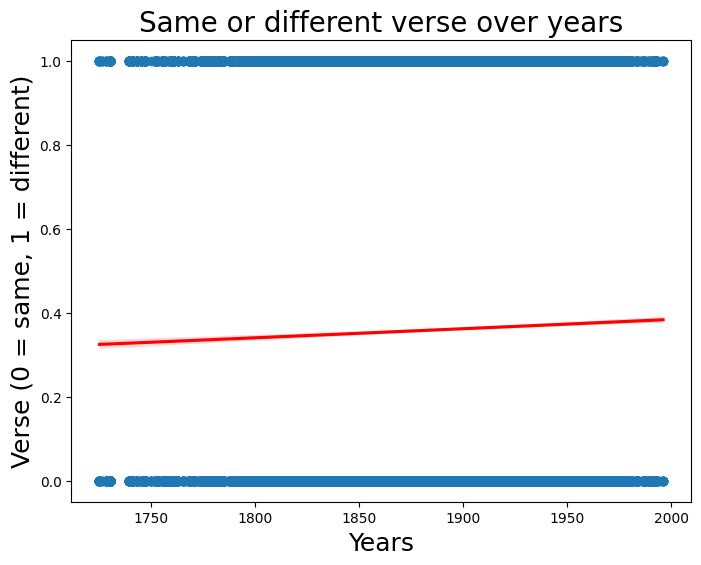

In [74]:
#Plot 6

plt.figure(figsize=(8, 6))

sns.regplot(x='year', y='Head_verse', data=sample_for_timeline, line_kws={"color": "red"}, logistic=True)
plt.title('Same or different verse over years', size=20)
plt.xlabel('Years', size=18)
plt.ylabel('Verse (0 = same, 1 = different)', size=18);

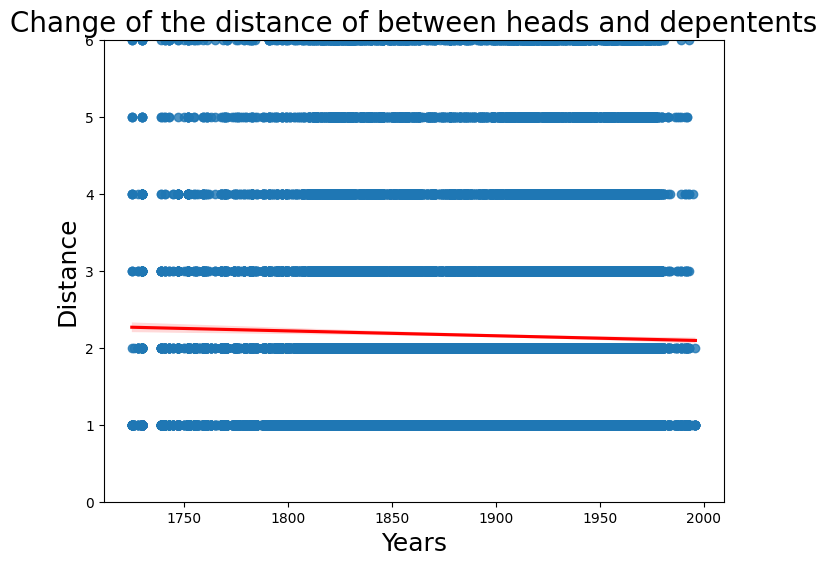

In [75]:
#Plot 7

plt.figure(figsize=(8, 6))

sns.regplot(x='year', y='head_distance', data=sample_for_timeline, line_kws={"color": "red"})
plt.title('Change of the distance of between heads and depentents', size=20)
plt.ylim((0, 6))
plt.xlabel('Years', size=18)
plt.ylabel('Distance', size=18);

As it is shown below, for both regressions "Year" predictor is statistically significant with a very small p-value for same / different verse opposition and bigger p-value for linear distance (but the latter lowers with the growth of sample size).

In [76]:
# Statistical inference for same or different verses over years

mod_log = smf.logit('Head_verse~year', data=for_timeline)
fit_year_verse = mod_log.fit()
fit_year_verse.summary()

Optimization terminated successfully.
         Current function value: 0.653887
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Head_verse   No. Observations:               490443
Model:                          Logit   Df Residuals:                   490441
Method:                           MLE   Df Model:                            1
Date:                Wed, 14 Dec 2022   Pseudo R-squ.:               0.0004461
Time:                        22:52:27   Log-Likelihood:            -3.2069e+05
converged:                       True   LL-Null:                   -3.2084e+05
Covariance Type:            nonrobust   LLR p-value:                 3.311e-64
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.2291      0.098    -22.675      0.000      -2.422      -2.036
year           0.0009   5.18e-05     16.892      0.000       0.001       0.001
==============================================================================
"""

In [77]:
# Statistical inference for change of the distance of between heads and depentents

mod_linear = smf.ols('head_distance~year', data=for_timeline)
fit_year_distance = mod_linear.fit()
fit_year_distance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          head_distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     96.64
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           8.34e-23
Time:                        22:52:27   Log-Likelihood:            -1.1861e+06
No. Observations:              490443   AIC:                         2.372e+06
Df Residuals:                  490441   BIC:                         2.372e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4044      0.128     26.656      0.000       3.154       3.655
year          -0.0007   6.73e-05     -9.831      0.000      -0.001      -0.001
==============================================================================
Omnibus:                   894839.033   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       9506112064.568
Skew:                          12.704   Prob(JB):                         0.00
Kurtosis:                     684.571   Cond. No.                     6.24e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Conclusions

In the present study I showed that the different syntactic relations behave differently with respect to the acceptability / probability for a dependent to be outside of the verse where its head is. The relations align with the following hierarchy _S > Adv, DO > Adj_, where the rightmost S appears on a different line in almost a half of cases, while leftmost Adj does it only 1 of 5 times. The difference between relations is statistically significant.

This finding partly confirm the original hypothesis about the ordering of syntactic relations, with the exception of adverb modifiers behavior. The latter, however, can be explained with heterogeneity of adverb class, which been discussed based on a case-study.

I showed that the observed difference cannot be attributed to solely the difference in the distributions of distances from the heads fo different syntactic relations, with multiple arguments presented.

Finally, I discussed the historical changes of the observed variables, which are in line with our knowledge about the development of Russian poetry: the later a text is written, the "more freedom" it shows.